In [ ]:
!pip install -q transformers
!pip install -q evaluate seqeval accelerate
!pip install -q datasets==2.7.0

In [ ]:
import cv2
import evaluate
import os
import torch

import numpy as np

from datasets import load_from_disk
from huggingface_hub import notebook_login
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    LiltForTokenClassification
)
from torch.utils.data import Dataset, DataLoader

In [3]:
notebook_login()

# Чтение данных

In [5]:
dataset = load_from_disk('/kaggle/input/piad-data-full/raw_data')

train_dataset = dataset['train']
eval_dataset = dataset['test']

label_list = train_dataset.features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(label_list)}
label2id = {k: v for v, k in enumerate(label_list)}

## PyTorch Dataset  
Создание кастомного датасета для модели LiLT, применение предобученного токенизатора

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example['image']
        words = example['words']
        boxes = example['bboxes']
        ner_tags = example['ner_tags']

        bbox = []
        labels = []
        for word, box, label in zip(words, boxes, ner_tags):
            n_word_tokens = len(tokenizer.tokenize(word))
            bbox.extend([box] * n_word_tokens)
            labels.extend([label] + ([-100] * (n_word_tokens - 1)))

        cls_box = sep_box = [0, 0, 0, 0]
        bbox = [cls_box] + bbox + [sep_box]
        labels = [-100] + labels + [-100]

        encoding = self.tokenizer(' '.join(words), truncation=True, max_length=512)
        sequence_length = len(encoding.input_ids)

        labels = labels[:sequence_length]
        bbox = bbox[:sequence_length]

        encoding['bbox'] = bbox
        encoding['labels'] = labels

        return encoding

In [7]:
tokenizer = AutoTokenizer.from_pretrained('nielsr/lilt-xlm-roberta-base')

train_lilt_dataset = CustomDataset(train_dataset, tokenizer)
eval_lilt_dataset = CustomDataset(eval_dataset, tokenizer)

tokenizer_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

# PyTorch DataLoader
Создание DataLoader для обучения по батчам

In [8]:
def collate_fn(features):
    boxes = [feature['bbox'] for feature in features]
    labels = [feature['labels'] for feature in features]

    batch = tokenizer.pad(features, padding='max_length', max_length=512)

    sequence_length = torch.tensor(batch['input_ids']).shape[1]
    batch['labels'] = [labels_example + [-100] * (sequence_length - len(labels_example)) for labels_example in labels]
    batch['bbox'] = [boxes_example + [[0, 0, 0, 0]] * (sequence_length - len(boxes_example)) for boxes_example in boxes]

    batch = {k: torch.tensor(v) for k, v in batch.items()}

    return batch

train_dataloader = DataLoader(train_lilt_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)
eval_dataloader = DataLoader(eval_lilt_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Обучение модели

In [109]:
model = LiltForTokenClassification.from_pretrained('nielsr/lilt-xlm-roberta-base', id2label=id2label)
metric = evaluate.load('seqeval')

Some weights of LiltForTokenClassification were not initialized from the model checkpoint at nielsr/lilt-xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Удаление лишних токенов
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f'{key}_{n}'] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            'precision': results['overall_precision'],
            'recall': results['overall_recall'],
            'f1': results['overall_f1'],
            'accuracy': results['overall_accuracy'],
        }

In [111]:
class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return train_dataloader

    def get_eval_dataloader(self, eval_dataset=None):
        return eval_dataloader

training_args = TrainingArguments(
    output_dir='test',
    num_train_epochs=20,
    learning_rate=5e-5,
    evaluation_strategy='steps',
    eval_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1'
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_lilt_dataset,
    eval_dataset=eval_lilt_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

torch.cuda.empty_cache()

trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, bu

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
10,No log,1.266415,0.000000,0.000000,0.000000,0.737921
20,No log,0.987362,0.016949,0.005128,0.007874,0.784498
30,No log,0.819097,0.104167,0.025641,0.041152,0.819604
40,No log,0.747611,0.084337,0.035897,0.050360,0.818909
50,No log,0.603802,0.207447,0.200000,0.203655,0.846368
60,No log,0.603818,0.260504,0.317949,0.286374,0.866875
70,No log,0.489271,0.399103,0.456410,0.425837,0.898505
80,No log,0.404543,0.471111,0.543590,0.504762,0.910671
90,No log,0.416405,0.410646,0.553846,0.471616,0.908238
100,No log,0.359773,0.465863,0.594872,0.522523,0.910671


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=360, training_loss=0.2327796088324653, metrics={'train_runtime': 961.3048, 'train_samples_per_second': 3.578, 'train_steps_per_second': 0.374, 'total_flos': 956961260912640.0, 'train_loss': 0.2327796088324653, 'epoch': 20.0})

# Загрузка на Hugging Face

In [112]:
model.push_to_hub('koshkidadanet/lilt-xlm-roberta-base-finetuned-piad')

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/koshkidadanet/lilt-xlm-roberta-base-finetuned-piad/commit/fd8326c994a2f7ea4a5362516c0f245a4d054996', commit_message='Upload LiltForTokenClassification', commit_description='', oid='fd8326c994a2f7ea4a5362516c0f245a4d054996', pr_url=None, pr_revision=None, pr_num=None)

# Проверка модели

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


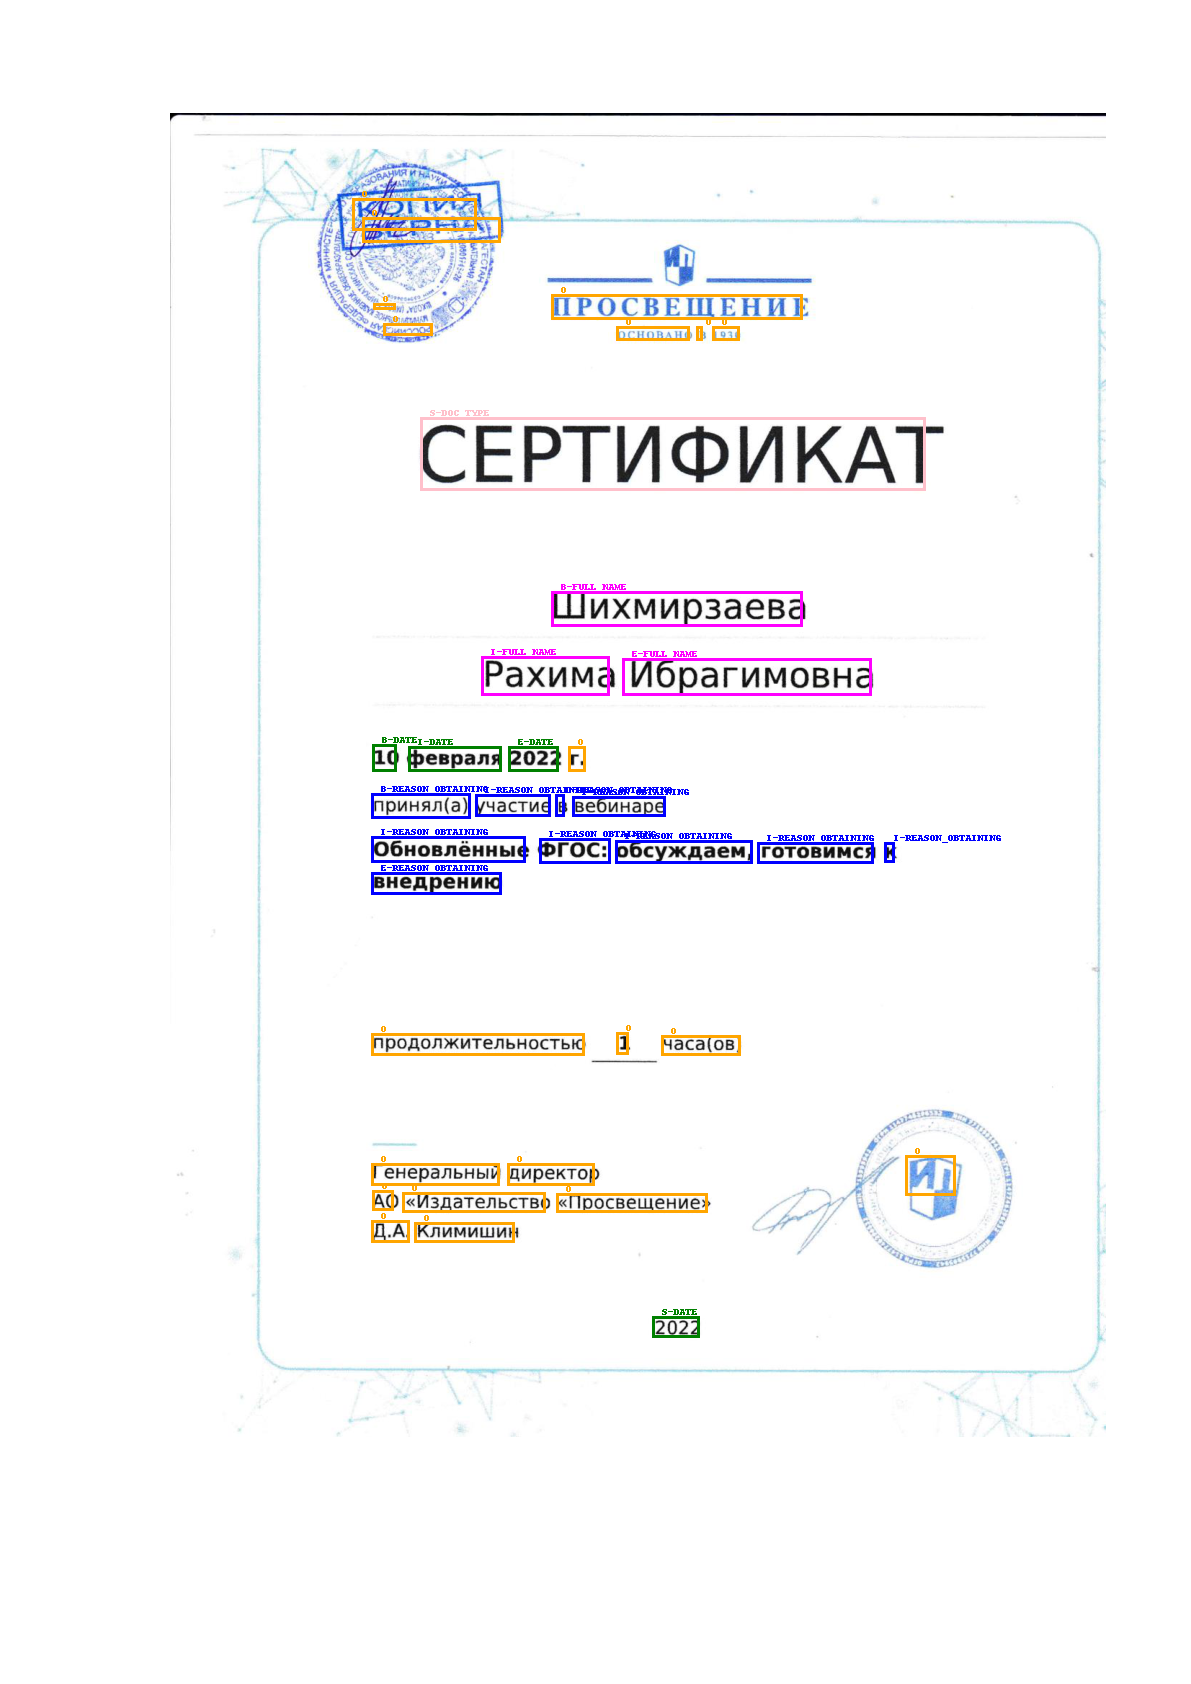

In [9]:
label2color = {
    'B-DATE': 'green',
    'B-DOC_TYPE': 'pink',
    'B-PLACE': 'yellow',
    'B-FULL_NAME': 'magenta',
    'B-REASON_OBTAINING': 'blue',
    'E-DATE': 'green',
    'E-DOC_TYPE': 'pink',
    'E-PLACE': 'yellow',
    'E-FULL_NAME': 'magenta',
    'E-REASON_OBTAINING': 'blue',
    'I-DATE': 'green',
    'I-DOC_TYPE': 'pink',
    'I-PLACE': 'yellow',
    'I-FULL_NAME': 'magenta',
    'I-REASON_OBTAINING': 'blue',
    'S-DATE': 'green',
    'S-DOC_TYPE': 'pink',
    'S-PLACE': 'yellow',
    'S-FULL_NAME': 'magenta',
    'S-REASON_OBTAINING': 'blue',
    'O': 'orange',
}


def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    draw = ImageDraw.Draw(image)
#     font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
#     font = ImageFont.truetype(font_path, size=24)

    for prediction, box in zip(predictions, normalizes_boxes):
        draw.rectangle(box, outline=label2color[prediction], width=3)
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction]) # font=font
    return image


def word_indices(bbox_list):
    '''
    Функция для очистки индексов от предсказаний по лишним токенам.
    Модель предоставляет предсказаня для токенов на уровне символов, 
    а требуются предсказания на уровне слов.
    '''
    occurrences = []
    indices = []
    for i, bbox in enumerate(bbox_list):
        if bbox not in occurrences and bbox != [0, 0, 0, 0]:
            occurrences.append(bbox)
            indices.append(i)
            
    return indices


def run_inference(dataloader, model):
    predictions = []
    
    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        bboxes = batch['bbox']
        
        outputs = model(input_ids=input_ids, bbox=bboxes, attention_mask=attention_mask)
        token_predictions = outputs.logits.argmax(-1).squeeze().tolist()
        
        indices = word_indices(bboxes.squeeze().tolist())
        word_predictions = [token_predictions[i] for i in indices]
        
        predictions.append(word_predictions)
        
    return predictions

model = LiltForTokenClassification.from_pretrained('koshkidadanet/lilt-xlm-roberta-base-finetuned-piad')

test_data = dataset['test']
test_dataloader = DataLoader(CustomDataset(test_data, tokenizer), batch_size=1, collate_fn=collate_fn)

predictions = run_inference(test_dataloader, model=model)
    
labels = [[model.config.id2label[p] for p in pred] for pred in predictions]
draw_boxes(test_data[0]['image'], test_data[0]['bboxes'], labels[0])

# for i in range(len(predictions)):
#     display(draw_boxes(dataset[i]['image'], dataset[i]['bboxes'], labels[i]))

# Подсчет метрики

* 0.877 - все классы
* 0.927 - классы без reason_obtaining

In [11]:
# считаем macro f1, так как macro подходит для несбалансированных классов
f1_scores = []
for pred, true_tags in zip(predictions, test_data['ner_tags']):
    f1 = f1_score(pred, true_tags[:len(pred)], average='macro')
    f1_scores.append(f1)
average_f1 = sum(f1_scores) / len(f1_scores)
average_f1

0.8774325762572468